explenation on how to calculate ball recovery time: https://www.fifatrainingcentre.com/en/fwc2022/efi-metrics/efi-metric--ball-recovery-time.php

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
with open('../../data/whoscored/data.json', 'r') as file:
    data = json.load(file)


In [3]:
events = [event for event in data['matchCentreData']['events']]
len(events)

1653

In [4]:
events_df = pd.DataFrame(pd.json_normalize(events, sep='_'))
events_df = events_df.drop(columns=['period_value', 'type_value', 'outcomeType_value', 'cardType_value', 'id'])

events_df['team_name'] = ''
events_df.loc[events_df['teamId'] == data['matchCentreData']['home']['teamId'], 'team_name'] = 'Barcelona'
events_df.loc[events_df['teamId'] == data['matchCentreData']['away']['teamId'], 'team_name'] = 'Real Madrid'

events_df.loc[events_df['second'].isna(), 'second'] = 0
events_df['tot_seconds'] = events_df.apply(lambda row: int(row['expandedMinute']) * 60 + int(row['second']), axis=1)
events_df = events_df.sort_values(by=['tot_seconds'])
print(events_df.columns)

Index(['eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute',
       'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'period_displayName',
       'type_displayName', 'outcomeType_displayName', 'playerId', 'endX',
       'endY', 'goalMouthZ', 'goalMouthY', 'isGoal', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'cardType_displayName', 'team_name', 'tot_seconds'],
      dtype='object')


In [5]:
# Uncomment to view event history
# pd.set_option('display.max_rows', 1000)
# events_df[['minute', 'second', 'tot_seconds','team_name', 'type_displayName', 'outcomeType_displayName', ]][:1000]

In [6]:
def calculate_ball_recovery_time(df, half, start=None, end=None, debug=False):
    # only_play_time=True - time of fauls, substitution, corners, goal celebration is not counted to any of the team.
    
    df_half = df[df['period_displayName'] == half]

    start_half_time = df_half.iloc[0].minute
    end_half_time =  df_half.iloc[-1].minute

    if debug:
        print(f"{start_half_time=}, {end_half_time=}")

    # 2nd time starts from 45 min, we need to calculate margin from additional time in 1st half
    expanded_time = 0
    if half == 'SecondHalf':
        expanded_time = df_half.iloc[0].expandedMinute - 45
        
    if start is not None:
        if start < start_half_time or start > end_half_time:
            print(f"Invalid start time {start}. Half time: ({start_half_time} - {end_half_time})")
            return
            
        start_time_sec_exp = (start + expanded_time) * 60
    else:
        start_time_sec_exp = df_half.iloc[0].tot_seconds
        
    if end is not None:
        if end < start_half_time or end > end_half_time or (start and end < start):
            print(f"Invalid end time {end}. Half time: ({start_half_time} - {end_half_time})")
            return
            
        end_time_sec_exp = (end + expanded_time) * 60
    else:
        end_time_sec_exp = df_half.iloc[-1].tot_seconds        
    
    recovery_time_start = start_time_sec_exp
    recovery_team = ''
    control_team = ''
    # 1st number in list corresponds to number of regained recoverys, second number correspond to total time which takes to regain recovery
    recovery_time = {'Barcelona' : [0, 0],
                    'Real Madrid' : [0, 0]}
    if debug:
        print(f"true minutes start end {start_time_sec_exp/60}, {end_time_sec_exp/60}")
    for _, row in df_half[df_half['tot_seconds'] > start_time_sec_exp].iterrows():
        if row['tot_seconds'] > end_time_sec_exp:
            break
        # Check for events that contribute to ball control
        # note, ThrowIn is a qualifier of Pass event
        if row['type_displayName'] in ['Pass', 'TakeOn', 'KeeperPickup', 'ShieldBallOpp'
                                        'BallRecovery', 'BallTouch', 
                                        'Aerial'] and row['outcomeType_displayName'] == 'Successful':
            if control_team != row['team_name']:
                if control_team == '':
                    control_team = row['team_name']
                    recovery_team = 'Barcelona' if control_team == 'Real Madrid' else 'Real Madrid'
                    recovery_time_start = row['tot_seconds']
                else:
                    if debug:
                        print(f"({row['minute']}:{row['second']}) event: {row['type_displayName']}, team {recovery_team} receives {row['tot_seconds'] - recovery_time_start} sec")
                    recovery_time[recovery_team][1] += row['tot_seconds'] - recovery_time_start
                    recovery_time[recovery_team][0] += 1
                    recovery_time_start = row['tot_seconds']
                    
                    recovery_team = control_team
                    control_team = row['team_name']
                    

    if recovery_team:
        if debug:
            print(f"(end) team {recovery_team} receives {end_time_sec_exp - recovery_time_start} sec")
        recovery_time[recovery_team][1] += end_time_sec_exp - recovery_time_start
    
    return recovery_time 
        

In [7]:
calculate_ball_recovery_time(events_df, 'FirstHalf')

{'Barcelona': [38, 1395], 'Real Madrid': [39, 1426]}

In [8]:
calculate_ball_recovery_time(events_df, 'SecondHalf')

{'Barcelona': [32, 1570], 'Real Madrid': [32, 1493]}

# Visualization

In [25]:
# function is taken from src/korotkova/rm_barca_main_stat.ipynb

import numpy as np
import re

def show_stats_data(data: dict):
    labels = list(data.keys())
    values = list(data.values())

    def extract_numeric(value):
        if isinstance(value, str):
            # Extract numeric part using regular expression
            numeric_part = re.search(r'\d+(\.\d+)?', value)
            if numeric_part:
                return float(numeric_part.group())
        return float(value)

    float_values = [[extract_numeric(value)
                    for value in sublist] for sublist in values]

    first_team = [el[0] for el in float_values]
    second_team = [el[1] for el in float_values]
    fig, ax = plt.subplots(figsize=(10, 6))

    sum_team = [first_team[i] + second_team[i]
                for i in range(min(len(first_team), len(second_team)))]

    first_team_normalized = [first_team[i] * 100 / sum_team[i]
                             for i in range(min(len(first_team), len(sum_team)))]
    second_team_normalized = [second_team[i] * 100 / sum_team[i]
                              for i in range(min(len(second_team), len(sum_team)))]

    p1 = ax.barh(labels, [-val for val in first_team_normalized],
                 color='indianred', label='Barcelona', height=0.5)
    p2 = ax.barh(labels, second_team_normalized,
                 color='skyblue', label='Real Madrid',  height=0.5)

    for rect in p1:
        width = rect.get_width()
        ax.text(width, rect.get_y() + rect.get_height() / 2,
                f'{first_team[p1.index(rect)]}', ha='right', va='center')

    for rect in p2:
        width = rect.get_width()
        ax.text(width, rect.get_y() + rect.get_height() / 2,
                f'{second_team[p2.index(rect)]}', ha='left', va='center')

    ax.legend(bbox_to_anchor=(1.20, 1), loc='upper right') 
    ax.set_xticks([])
    plt.show()

## Number of recoveries

In [26]:
fh = calculate_ball_recovery_time(events_df, 'FirstHalf')
sh_start_52 = calculate_ball_recovery_time(events_df, 'SecondHalf', end=52) #end minute is not including
sh_52_63 = calculate_ball_recovery_time(events_df, 'SecondHalf', start=52, end=63)
sh_63_78 = calculate_ball_recovery_time(events_df, 'SecondHalf', start=63, end=78)
sh_78_end = calculate_ball_recovery_time(events_df, 'SecondHalf', start=78)

recoveries_num = {'78 min - end match' : [sh_78_end['Barcelona'][0], sh_78_end['Real Madrid'][0]],
                    '63 min - 78 min' : [sh_63_78['Barcelona'][0], sh_63_78['Real Madrid'][0]],
                    '52 min - 63 min' : [sh_52_63['Barcelona'][0], sh_52_63['Real Madrid'][0]],
                    '2nd half start - 52 min' : [sh_start_52['Barcelona'][0], sh_start_52['Real Madrid'][0]],
                    '1st half' : [fh['Barcelona'][0], fh['Real Madrid'][0]],
}

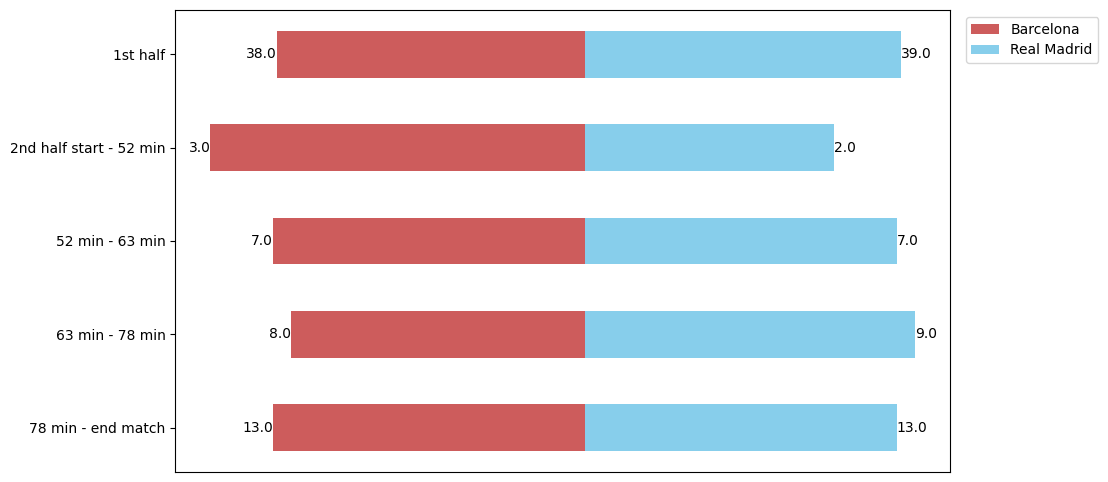

In [27]:
show_stats_data(recoveries_num)

# Average recovery time in seconds

In [28]:
recoveries_avg = {'78 min - end match' : [round(sh_78_end['Barcelona'][1] / sh_78_end['Barcelona'][0]), 
                                          round(sh_78_end['Real Madrid'][1] / sh_78_end['Real Madrid'][0])],
                    '63 min - 78 min' : [round(sh_63_78['Barcelona'][1] / sh_63_78['Barcelona'][0]), 
                                         round(sh_63_78['Real Madrid'][1] / sh_63_78['Real Madrid'][0])],
                    '52 min - 63 min' : [round(sh_52_63['Barcelona'][1] / sh_52_63['Barcelona'][0]), 
                                         round(sh_52_63['Real Madrid'][1] / sh_52_63['Real Madrid'][0])],
                    '2nd half start - 52 min' : [round(sh_start_52['Barcelona'][1] / sh_start_52['Barcelona'][0]), 
                                                 round(sh_start_52['Real Madrid'][1] / sh_start_52['Real Madrid'][0])],
                    '1st half' : [round(fh['Barcelona'][1] / fh['Barcelona'][0]), 
                                  round(fh['Real Madrid'][1] / fh['Real Madrid'][0])],
}

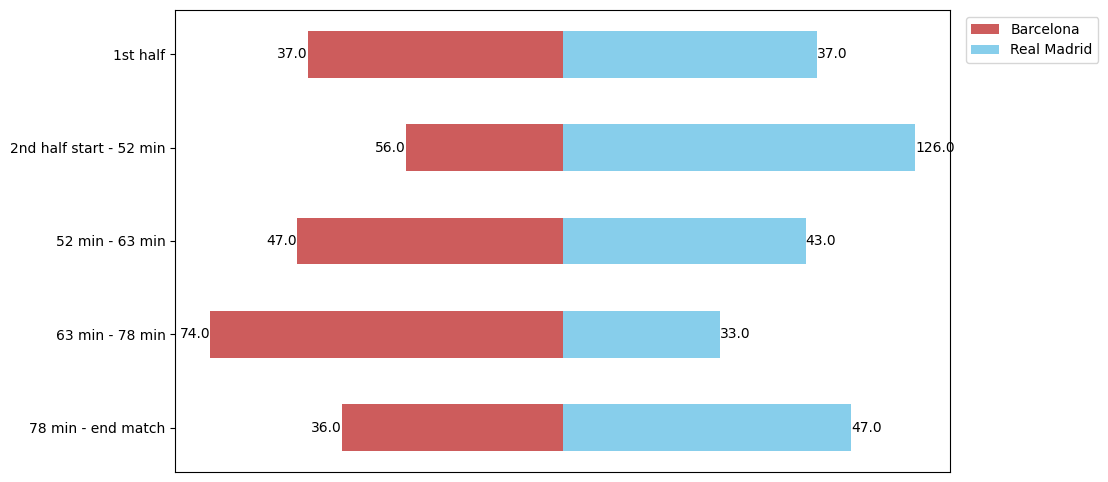

In [29]:
show_stats_data(recoveries_avg)